In [1]:
import numpy as np 
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

/Users/claudiacastro/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Segmentación

El objetivo principal de esta tarea es segmentar a los clientes en grupos distintos y homogéneos, con el fin de obtener un conocimiento más profundo de nuestra base de clientes y mejorar la estrategia comercial. 

El análisis de los clusters permitirá identificar patrones y características clave de cada grupo, lo que facilitará la orientación de nuestras acciones comerciales de manera más efectiva. Los resultados de esta segmentación se presentarán con una descripción clara y visual de cada cluster, destacando las diferencias entre ellos.

---

Carga de los dataset ya limpios que se encuentran en s3 de AWS, se unen y se genera un nuevo dataset que se guarda en igual en s3 de AWS para su uso directo.

In [2]:

# productos
#prod_df_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/prod_df_cleaned.parquet") 

# sociodemografico
#sdg_df_cleaned = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/sociodemographic_df_cleaned.parquet')

# comercial activity clean
#ca_df_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/commercial_activity_df_clean.parquet") 

# merge de los tres dataframes
#df_1_merge = pd.merge(prod_df_cleaned,sdg_df_cleaned, how="inner" ,on=['pk_cid','pk_partition'])

#df_2_merge = pd.merge(df_1_merge,ca_df_cleaned, how="inner",on=['pk_cid','pk_partition'])

#df_full_cleaned = df_2_merge.copy()

#df_full_cleaned.to_parquet("/Users/claudiacastro/df_full_cleaned.parquet")

Este dataset contiene la limpieza y las nuevas columnas creadas en la etapa anterior.

In [3]:
# Cargando los datos directamente de s3 de AWS
df_full_cleaned = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/df_full_cleaned.parquet")
df_full_clean = df_full_cleaned.copy()

In [4]:
df_full_clean

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,country_id,region_code,gender,age,deceased,salary,grupo_edad,entry_date,entry_channel,active_customer,segment,categoria_antiguedad
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,29.0,H,35,N,"87,218.100",Adultos jóvenes,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,13.0,V,23,N,"35,548.740",Jóvenes,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,13.0,V,23,N,"122,179.110",Jóvenes,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,50.0,H,22,N,"119,775.540",Jóvenes,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,50.0,V,23,N,"88,419.990",Jóvenes,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,50.0,V,22,N,"43,912.170",Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,26.0,V,23,N,"23,334.990",Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,50.0,H,47,N,"90,123.060",Adultos,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,ES,50.0,H,22,N,"199,592.820",Jóvenes,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años


# Procedimiento para la segmentación de clientes:

La segmentación de clientes implica agrupar a los clientes en segmentos distintos, cada uno caracterizado por ciertas propiedades que describen su comportamiento y relación con la empresa. Aunque existen innumerables características que podrían utilizarse para este propósito, la elección de las características óptimas depende en gran medida del objetivo comercial que se desee alcanzar con dicha segmentación. Por lo tanto, no existe un único enfoque correcto ni una fórmula universal para llevar a cabo una Segmentación de Clientes.

Las variables seleccionadas para el modelo son fundamentales, ya que definirán las diferencias clave entre los grupos. Para realizar una segmentación efectiva que permita un entendimiento más profundo de nuestra base de clientes y la alineación de nuestras estrategias comerciales, es crucial elegir variables que reflejen el comportamiento del cliente en relación con nuestros productos o servicios. 

1. Técnica de Segmentación: Clustering

Existen varias técnicas de segmentación pero para este caso como el dataset contiene una variedad de variables tanto demográficas como de comportamiento, se realiza la técnica de segmentación basada en Clustering, específicamente K-means, que proporciona una visión holística de los diferentes tipos de clientes.

---
2. Selección de Variables:

Una vez definido la técnica de segmentación, a continuación se definen 3 análisis basados en el clustering que se va a implementar según las diferentes variables presentes: 

Para construir clusters significativos, es crucial elegir variables que reflejen tanto el comportamiento financiero de los clientes como sus características demográficas. Aquí te sugiero una selección de variables que podrías usar, junto con el razonamiento para cada una:

Variables Demográficas:

1.	age (Edad): Es fundamental para entender la etapa de vida en la que se encuentra el cliente, lo que afecta sus necesidades financieras.

2.	country_id (País de residencia): Podría ser útil para identificar variaciones geográficas en el comportamiento de los clientes.
3.	region_code (Provincia): Para segmentar a nivel más granular dentro de un país, especialmente si hay diferencias regionales significativas.
4.  gender (Sexo): Aunque menos relevante en algunos casos, podría influir en la preferencia por ciertos productos financieros.
5.	salary (Ingresos brutos): Indica la capacidad de compra e inversión del cliente, crucial para segmentar en términos de valor potencial.

Variables de Comportamiento Financiero:

1.	active_customer (Actividad del cliente): Indicador de si el cliente está activamente utilizando los productos, importante para identificar clientes leales o en riesgo de abandono.

2.	entry_channel (Canal de captación): Puede influir en el comportamiento inicial y la adopción de productos del cliente.

3.	credit_card, debit_card (Tarjetas de crédito/débito): Reflejan el uso de productos financieros cotidianos y la disposición del cliente a utilizar crédito.
	
4.	em_account_p, em_account_pp, em_acount, emc_account (Cuentas de easyMoney): Estas variables muestran el nivel de compromiso del cliente con los diferentes productos de la empresa, siendo clave para entender la amplitud de su relación con la empresa.
	
5.	loans, mortgage (Préstamos e Hipotecas): Indican el nivel de deuda y el compromiso financiero a largo plazo del cliente.

6.	funds, securities (Fondos y Valores): Reflejan la predisposición del cliente a invertir y su perfil de riesgo.

7.	short_term_deposit, long_term_deposit (Depósitos a corto y largo plazo): Muestran las preferencias del cliente por la seguridad y el rendimiento financiero a corto o largo plazo.

8.	payroll, payroll_account (Domiciliaciones y cuentas bonificadas): Indican el nivel de vinculación del cliente con la empresa a través de la domiciliación de su salario y otros ingresos recurrentes.

9.	pension_plan (Plan de pensiones): Refleja la planificación a largo plazo del cliente y su preocupación por la jubilación.

10. categoria_antiguedad: Muestra la retención del cliente a largo plazo.


---
3. Implementación del Clustering:

Preprocesamiento:

- Análisis de variables para identificar relevancia. Agrupación por Clientes.
  
- Se analiza la correlación entre las variables para identificar y eliminar aquellas que estén altamente correlacionadas y así evitar la redundancia y mejorar la eficiencia del modelo de clustering.

- Se estandarizan las variables numéricas para que tengan igual peso en el análisis.

Ejecución del Clustering:

- Se realiza un análisis de clustering utilizando K-means
  
- Determina el número óptimo de clusters usando técnicas como el método del codo o el análisis de la silueta.

Interpretación de los Clusters:

	•	Analiza cada cluster para entender sus características principales. Por ejemplo, podrías encontrar un grupo de clientes jóvenes con altos ingresos que prefieren productos de inversión, y otro de clientes mayores con preferencias por productos de ahorro a largo plazo.

1. Acciones Comerciales:

Una vez que tengas los clusters, podrás desarrollar estrategias de marketing personalizadas. Por ejemplo:

	•	Clientes Jóvenes con Alto Uso de Crédito: Ofertas de tarjetas de crédito con recompensas.
	•	Clientes Mayores con Depósitos a Largo Plazo: Productos financieros seguros como bonos y certificados de depósito.

Esta estrategia te permitirá aprovechar al máximo los datos disponibles, creando segmentos de clientes con un alto grado de diferenciación y relevancia para tus objetivos comerciales.






---

## Implementación del Clustering (K-means)

### Preprocesamiento

En esta sección, se llevará a cabo un análisis de las variables presentes en el dataset con el objetivo de identificar aquellas que son más relevantes para el estudio, lo cual es crucial para simplificar el modelo, mejorar el rendimiento y facilitar la interpretación de los resultados.

Se crea un dataframe vacío donde se va a ir agregando las variables correspondiente para el analisis de clustering

In [5]:
df_clustering =  pd.DataFrame()

Se agrupan los clientes segun los productos a lo largo de las particiones, se calcula la media por cada producto para indicar el grado de usabilidad.

In [6]:
productos = df_full_clean.columns[2:17]
productos
df_productos_usos = df_full_clean.groupby("pk_cid")[productos].mean()
df_productos_usos.head()

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
pk_cid,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,0.889
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,1.000


Se agrupa por cliente para obtener el maximo de producto contratado por cada cliente hasta la fecha

In [7]:
df_cant_prod_contratados = df_full_clean.groupby("pk_cid")["num_products_contracts"].max()
df_cant_prod_contratados

pk_cid
15891      1
16063      0
16203      1
16502      2
17457      3
          ..
1553685    0
1553686    0
1553687    0
1553688    0
1553689    0
Name: num_products_contracts, Length: 456373, dtype: int64

Region_Code

Para tratar la columna region_code se puede utilizar One-Hot Encoding y/o Label Encoding pero en este contexto y para evitar la alta dimensionalidad y relaciones ordinales incorrectas, y así asegurar un mejor rendimiento y precisión del modelo KMeans, se decide utilizar el Frequency Encoding ya que se busca una representación más detallada que capture la variabilidad en la distribución de clientes por provincia. 

Nota: otro enfoque pudiera ser distinguir entre áreas con alta y baja densidad de clientes, y con una codificación binaria para las provincias más pobladas hubiese sido suficiente.



Pasos para Aplicar Frequency Encoding

- Calcular la Frecuencia de Cada Provincia: Primero, cuentas cuántas veces aparece cada provincia en el dataset.

- Reemplazar la Provincia por su Frecuencia: Luego, asignas la frecuencia calculada a cada cliente en función de su provincia de residencia.

In [8]:
# Paso 1: Calcular la frecuencia de cada provincia
frecuencias_provincia = df_full_clean['region_code'].value_counts(normalize=True)  # normalize=True para obtener las frecuencias relativas

# Paso 2: Mapear las frecuencias a la columna de provincia
df_full_clean['region_code_encoded'] = df_full_clean['region_code'].map(frecuencias_provincia)

df_region_code_frecuency = df_full_clean.groupby("pk_cid")["region_code_encoded"].last()

# Verificar los resultados
print(df_full_clean[['region_code', 'region_code_encoded']].head())

  region_code  region_code_encoded
0        29.0                0.032
1        13.0                0.012
2        13.0                0.012
3        50.0                0.022
4        50.0                0.022


Variables country_id, deceased, em_account_pp y entry_date

In [9]:
df_full_clean["deceased"].value_counts()

# eliminar la columna entry_date que tampoco aporta información
df_full_clean.drop(columns=['entry_date'], inplace=True)

df_full_clean['country_id'] = np.where( df_full_clean['country_id'] == 'ES', 1, 0)
df_full_clean.groupby('pk_cid')['country_id'].last().value_counts()

df_full_clean["em_account_pp"].value_counts()

em_account_pp
0    5962924
Name: count, dtype: int64

La variable deseaced no se va a tener en cuenta en el analisis, así como la variable em_account_pp y country_id por no brindar suficiente información

Para el resto de las variables no se precisa ninguna transformación ya que vienen limpias de la Tarea 1, así que nos quedaremos con el ultimo valor que practicamente viene siendo el mismo en todas las particiones.

In [10]:
clean_variable = [	"gender",	"age",	"salary",	"grupo_edad",	"entry_channel",	"active_customer",
                  "segment",	"categoria_antiguedad"]
df_clean_variables = df_full_clean.groupby('pk_cid')[clean_variable].last()
df_clean_variables

,gender,age,salary,grupo_edad,entry_channel,active_customer,segment,categoria_antiguedad
pk_cid,,,,,,,,
15891,H,59,"99,034.080",Adultos mayores,KAT,0,02 - PARTICULARES,0-3 meses
16063,H,62,"99,034.080",Adultos mayores,KAT,0,02 - PARTICULARES,6-9 meses
16203,V,70,"128,676.480",Ancianos,KAT,1,01 - TOP,3-6 meses
16502,H,58,"99,034.080",Adultos mayores,KHN,1,02 - PARTICULARES,6-9 meses
17457,H,54,"102,405.750",Adultos,KAT,1,02 - PARTICULARES,1-2 años
...,...,...,...,...,...,...,...,...
1553685,V,52,"96,524.130",Adultos,Otros,0,03 - UNIVERSITARIO,0-3 meses
1553686,H,30,"86,619.180",Adultos jóvenes,Otros,0,03 - UNIVERSITARIO,0-3 meses
1553687,V,21,"88,419.990",Jóvenes,Otros,0,03 - UNIVERSITARIO,0-3 meses


Ahora pasamos a unir los dataset que se han ido creando a lo largo de este analisis para finalmente obtener el dataset para la segmentación.

In [11]:
# inicializamos el dataframe de clustering con el dataframe de productos_usos
df_clustering = df_productos_usos.copy()

# Uniendo el dataframe de df_clustering con el dataframe de cant_prod_contratados
df_clustering = df_clustering.join(df_cant_prod_contratados)

# Uniendo el dataframe de df_clustering con el dataframe de df_region_code_frecuency
df_clustering = df_clustering.join(df_region_code_frecuency)

# Uniendo el dataframe de df_clustering con el dataframe de df_clean_variables
df_clustering = df_clustering.join(df_clean_variables)

df_clustering


,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,region_code_encoded,gender,age,salary,grupo_edad,entry_channel,active_customer,segment,categoria_antiguedad
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,1,0.199,H,59,"99,034.080",Adultos mayores,KAT,0,02 - PARTICULARES,0-3 meses
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.199,H,62,"99,034.080",Adultos mayores,KAT,0,02 - PARTICULARES,6-9 meses
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,1,0.101,V,70,"128,676.480",Ancianos,KAT,1,01 - TOP,3-6 meses
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,0.889,2,0.199,H,58,"99,034.080",Adultos mayores,KHN,1,02 - PARTICULARES,6-9 meses
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,1.000,3,0.199,H,54,"102,405.750",Adultos,KAT,1,02 - PARTICULARES,1-2 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.012,V,52,"96,524.130",Adultos,Otros,0,03 - UNIVERSITARIO,0-3 meses
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.049,H,30,"86,619.180",Adultos jóvenes,Otros,0,03 - UNIVERSITARIO,0-3 meses
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.199,V,21,"88,419.990",Jóvenes,Otros,0,03 - UNIVERSITARIO,0-3 meses


Para llevar a cabo el análisis de correlacion lo primero que se hace es llevar todas las columnas categóricas a numericas.

In [12]:
# verificando los tipos de datos y corigiendo los que sean necesarios
df_clustering["region_code_encoded"] = df_clustering["region_code_encoded"].astype("float")
df_clustering["grupo_edad"] = df_clustering["grupo_edad"].astype("category")
df_clustering["entry_channel"] = df_clustering["entry_channel"].astype("category")
df_clustering.dtypes

short_term_deposit         float64
loans                      float64
mortgage                   float64
funds                      float64
securities                 float64
long_term_deposit          float64
em_account_pp              float64
credit_card                float64
payroll                    float64
pension_plan               float64
payroll_account            float64
emc_account                float64
debit_card                 float64
em_account_p               float64
em_acount                  float64
num_products_contracts       int64
region_code_encoded        float64
gender                    category
age                          int64
salary                     float64
grupo_edad                category
entry_channel             category
active_customer              int32
segment                   category
categoria_antiguedad      category
dtype: object

In [13]:
# Identificar las columnas categóricas
columnas_categoricas = df_clustering.dtypes.loc[df_clustering.dtypes == "category"].index.tolist()

# Aplicar one-hot encoding usando pandas.get_dummies
df_numerico = pd.get_dummies(df_clustering, columns=columnas_categoricas, drop_first=True, dtype=int)

# Verificar el resultado
df_numerico

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,region_code_encoded,age,salary,active_customer,gender_V,gender_Unknown,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Otros,entry_channel_RED,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_1-2 años,categoria_antiguedad_2-3 años,categoria_antiguedad_Más de 3 años
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,1,0.199,59,"99,034.080",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.199,62,"99,034.080",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,1,0.101,70,"128,676.480",1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,0.889,2,0.199,58,"99,034.080",1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,1.000,3,0.199,54,"102,405.750",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.012,52,"96,524.130",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.049,30,"86,619.180",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.199,21,"88,419.990",0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


Una vez convertido las variables categóricas a numéricas, pasamos hacer el análisis de correlación

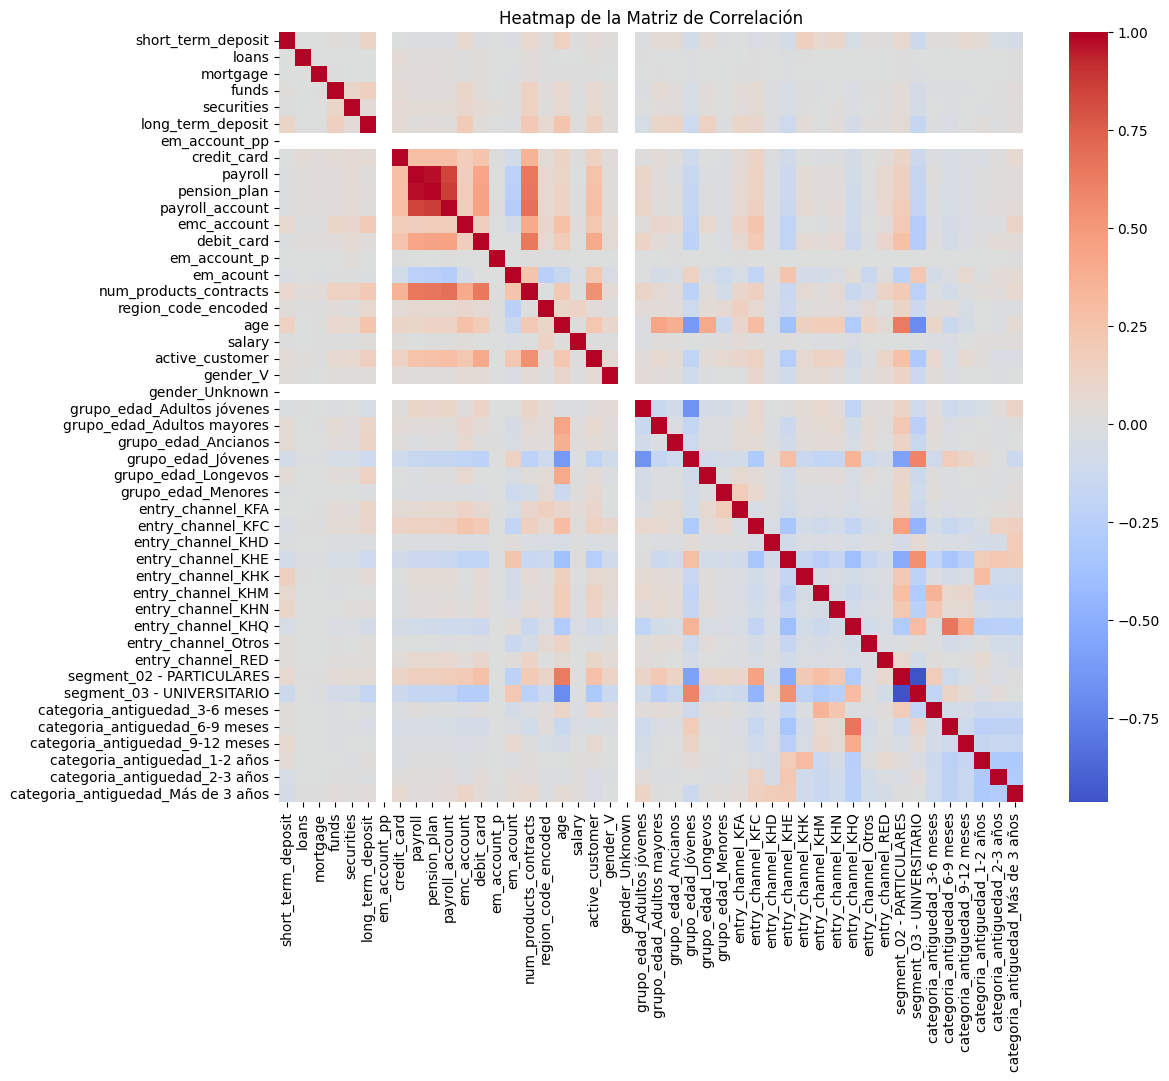

Pares de variables altamente correlacionadas:
('payroll', 'pension_plan')
('segment_02 - PARTICULARES', 'segment_03 - UNIVERSITARIO')


In [14]:
# Calcular la matriz de correlación
matriz_correlacion = df_numerico.corr()

# Visualizar la matriz de correlación utilizando un heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacion, cmap='coolwarm', center=0)
plt.title('Heatmap de la Matriz de Correlación')
plt.show()

# Identificar variables altamente correlacionadas
umbral = 0.9
correlaciones_altas = np.where(np.abs(matriz_correlacion) > umbral)
pares_correlacionados = [(matriz_correlacion.index[x], matriz_correlacion.columns[y]) for x, y in zip(*correlaciones_altas) if x != y and x < y]

print("Pares de variables altamente correlacionadas:")
for par in pares_correlacionados:
    print(par)

Vamos a analizar cada par de variables para determinar cuál es mejor eliminar:

En los dos casos, ambas variables representan a segmentos específicos de clientes. Por lo tanto aunque estén correlacionadas, se van a mantener ya que pueden ofrecer diferentes insights.


### Estandarización de las variables numéricas

In [15]:
# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the data
df_numerico_estandarizado = scaler.fit_transform(df_numerico)

# Convert the result to a DataFrame
df_numerico_estandarizado = pd.DataFrame(df_numerico_estandarizado , columns=df_numerico.columns)

# Verify the results
df_numerico_estandarizado

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,region_code_encoded,age,salary,active_customer,gender_V,gender_Unknown,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Otros,entry_channel_RED,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_1-2 años,categoria_antiguedad_2-3 años,categoria_antiguedad_Más de 3 años
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.500,0.000,1.869,2.429,0.320,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,1.869,2.643,0.320,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-1.000,0.000,1.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.167,0.000,0.694,3.214,1.213,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,1.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,-0.111,1.000,1.869,2.357,0.320,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,-1.000,0.000,1.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,0.000,2.000,1.869,2.071,0.421,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-1.000,0.000,0.000,0.000,1.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456368,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,-0.371,1.929,0.244,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
456369,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,0.071,0.357,-0.054,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
456370,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,1.869,-0.286,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
456371,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,-0.372,1.286,0.244,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


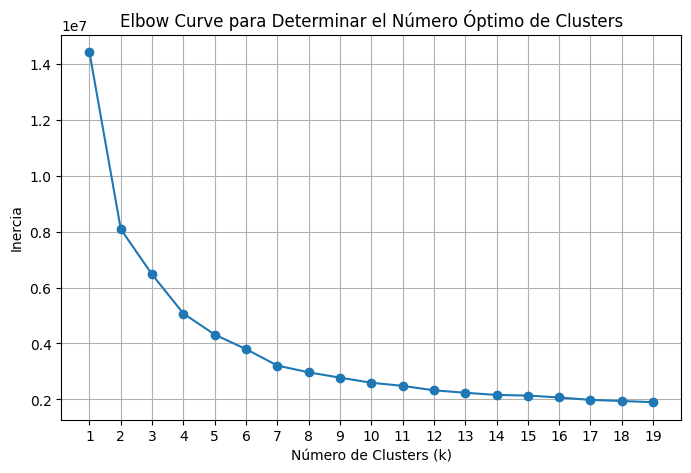

In [16]:
# Definir un rango de k (número de clusters) para probar
rango_k = range(1, 20)
inercias = []

# Aplicar K-means para cada valor de k y calcular la inercia
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_numerico_estandarizado)
    inercias.append(kmeans.inertia_)

# Graficar la Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(rango_k, inercias, marker='o', linestyle='-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Curve para Determinar el Número Óptimo de Clusters')
plt.xticks(rango_k)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

data = df_numerico_estandarizado.sample(frac=0.1, random_state=42)

# Calcular el coeficiente de silueta para diferentes valores de k
silhouette_scores = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters= k, random_state=42)
    labels = kmeans.fit_predict(data)
    score = silhouette_score(data, labels)
    silhouette_scores[k] = score

# Imprimir los coeficientes de silueta
print(silhouette_scores)

In [17]:
df_clustering

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,region_code_encoded,gender,age,salary,grupo_edad,entry_channel,active_customer,segment,categoria_antiguedad
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,1,0.199,H,59,"99,034.080",Adultos mayores,KAT,0,02 - PARTICULARES,0-3 meses
16063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.199,H,62,"99,034.080",Adultos mayores,KAT,0,02 - PARTICULARES,6-9 meses
16203,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.833,1,0.101,V,70,"128,676.480",Ancianos,KAT,1,01 - TOP,3-6 meses
16502,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.556,0.000,0.000,0.889,2,0.199,H,58,"99,034.080",Adultos mayores,KHN,1,02 - PARTICULARES,6-9 meses
17457,0.000,0.000,0.000,0.000,0.000,0.941,0.000,0.000,0.000,0.000,0.000,0.000,0.294,0.000,1.000,3,0.199,H,54,"102,405.750",Adultos,KAT,1,02 - PARTICULARES,1-2 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.012,V,52,"96,524.130",Adultos,Otros,0,03 - UNIVERSITARIO,0-3 meses
1553686,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.049,H,30,"86,619.180",Adultos jóvenes,Otros,0,03 - UNIVERSITARIO,0-3 meses
1553687,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.199,V,21,"88,419.990",Jóvenes,Otros,0,03 - UNIVERSITARIO,0-3 meses


Paso 1: Definir las Categorías

	1.	Cuentas Vendidas:
	•	short_term_deposit
	•	long_term_deposit
	•	payroll_account
	•	em_account_pp
	•	em_account_p
	•	em_acount
	•	emc_account
	2.	Ahorro e Inversión:
	•	funds
	•	securities
	•	pension_plan
	3.	Financiación:
	•	loans
	•	credit_card
	•	mortgage
	•	debit_card

In [18]:
# Crear nuevas columnas para las categorías
df_clustering['cuentas'] = df_clustering[['short_term_deposit', 'long_term_deposit', 'payroll_account', 
                             'em_account_pp', 'em_account_p', 'em_acount', 'emc_account']].mean(axis=1)

df_clustering['ahorro_inversion'] = df_clustering[['funds', 'securities', 'pension_plan']].mean(axis=1)

df_clustering['financiacion'] = df_clustering[['loans', 'credit_card', 'mortgage', 'debit_card']].mean(axis=1)

# Mostrar las primeras filas del DataFrame con las nuevas columnas
#print(df_clustering[['cuentas_vendidas', 'ahorro_inversion', 'financiacion']].head())

df_clustering.drop(columns=productos, inplace=True)

In [19]:
df_clustering

,num_products_contracts,region_code_encoded,gender,age,salary,grupo_edad,entry_channel,active_customer,segment,categoria_antiguedad,cuentas,ahorro_inversion,financiacion
pk_cid,,,,,,,,,,,,,
15891,1,0.199,H,59,"99,034.080",Adultos mayores,KAT,0,02 - PARTICULARES,0-3 meses,0.071,0.000,0.000
16063,0,0.199,H,62,"99,034.080",Adultos mayores,KAT,0,02 - PARTICULARES,6-9 meses,0.000,0.000,0.000
16203,1,0.101,V,70,"128,676.480",Ancianos,KAT,1,01 - TOP,3-6 meses,0.119,0.000,0.000
16502,2,0.199,H,58,"99,034.080",Adultos mayores,KHN,1,02 - PARTICULARES,6-9 meses,0.206,0.000,0.000
17457,3,0.199,H,54,"102,405.750",Adultos,KAT,1,02 - PARTICULARES,1-2 años,0.277,0.000,0.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0,0.012,V,52,"96,524.130",Adultos,Otros,0,03 - UNIVERSITARIO,0-3 meses,0.000,0.000,0.000
1553686,0,0.049,H,30,"86,619.180",Adultos jóvenes,Otros,0,03 - UNIVERSITARIO,0-3 meses,0.000,0.000,0.000
1553687,0,0.199,V,21,"88,419.990",Jóvenes,Otros,0,03 - UNIVERSITARIO,0-3 meses,0.000,0.000,0.000


In [20]:

"""
# Supongamos que tu DataFrame se llama 'df'
# Lista de canales considerados como principales (basado en frecuencia)
canales_principales = ['KHE', 'KHQ', 'KFC']

# Crear una nueva columna para categorizar los canales
df_clustering['entry_channel_group'] = df_clustering['entry_channel'].apply(lambda x: 'Canal Principal' if x in canales_principales else 'Canal Secundario')

# Mostrar las primeras filas del DataFrame con la nueva columna
#print(df_clustering[['entry_channel', 'entry_channel_group']].head())
df_clustering.drop(columns=['entry_channel'], inplace=True)
"""

"\n# Supongamos que tu DataFrame se llama 'df'\n# Lista de canales considerados como principales (basado en frecuencia)\ncanales_principales = ['KHE', 'KHQ', 'KFC']\n\n# Crear una nueva columna para categorizar los canales\ndf_clustering['entry_channel_group'] = df_clustering['entry_channel'].apply(lambda x: 'Canal Principal' if x in canales_principales else 'Canal Secundario')\n\n# Mostrar las primeras filas del DataFrame con la nueva columna\n#print(df_clustering[['entry_channel', 'entry_channel_group']].head())\ndf_clustering.drop(columns=['entry_channel'], inplace=True)\n"

Al mantener la variable segment, corremos el riesgo de redundancia, ya que los nuevos segmentos que definamos probablemente se solapen o contradigan con los existentes. Para evitar confusiones y garantizar que nuestras estrategias se basen en segmentos actuales y significativos, eliminaremos el segment anterior y utilizaremos los nuevos criterios de segmentación.

In [21]:
df_clustering.drop(columns=['segment'], inplace=True)
df_clustering.drop(columns=['grupo_edad'], inplace=True)
df_clustering.drop(columns=['gender'], inplace=True)
df_clustering.drop(columns=['entry_channel'], inplace=True)  
df_clustering.drop(columns=['region_code_encoded'], inplace=True)  

In [22]:
# Paso 1: Calcular la frecuencia de cada provincia
frecuencias_antigueda = df_clustering['categoria_antiguedad'].value_counts(normalize=True)  # normalize=True para obtener las frecuencias relativas

# Paso 2: Mapear las frecuencias a la columna de provincia
df_full_clean['categoria_antiguedad_encoded'] = df_clustering['categoria_antiguedad'].map(frecuencias_antigueda)

df_antiguedad_frecuency = df_full_clean.groupby("pk_cid")["categoria_antiguedad_encoded"].last()

# Verificar los resultados
#print(df_full_clean[['region_code', 'region_code_encoded']].head())
df_clustering.drop(columns=['categoria_antiguedad'], inplace=True)

In [23]:
"""
# Supongamos que tienes un DataFrame 'df' con una columna 'salary' que representa los salarios
# Asegúrate de que los valores de 'salary' estén en formato numérico
df_clustering['salary'] = df_clustering['salary'].replace(',', '', regex=True).astype(float)

# Calcular los percentiles para definir los umbrales
low_threshold = df_clustering['salary'].quantile(0.33)
high_threshold = df_clustering['salary'].quantile(0.66)

# Definir una función para clasificar los salarios
def categorize_salary(salary):
    if salary <= low_threshold:
        return 'Ingreso Bajo'
    elif salary <= high_threshold:
        return 'Ingreso Medio'
    else:
        return 'Ingreso Alto'

# Aplicar la función a la columna 'salary'
df_clustering['salary_category'] = df_clustering['salary'].apply(categorize_salary)

# Mostrar las primeras filas del DataFrame con la nueva columna
#print(df[['salary', 'salary_category']].head())
df_clustering.drop(columns=['salary'], inplace=True)
df_clustering["salary_category"] = df_clustering["salary_category"].astype("category")

df_clustering["entry_channel_group"] = df_clustering["entry_channel_group"].astype("category")

"""

'\n# Supongamos que tienes un DataFrame \'df\' con una columna \'salary\' que representa los salarios\n# Asegúrate de que los valores de \'salary\' estén en formato numérico\ndf_clustering[\'salary\'] = df_clustering[\'salary\'].replace(\',\', \'\', regex=True).astype(float)\n\n# Calcular los percentiles para definir los umbrales\nlow_threshold = df_clustering[\'salary\'].quantile(0.33)\nhigh_threshold = df_clustering[\'salary\'].quantile(0.66)\n\n# Definir una función para clasificar los salarios\ndef categorize_salary(salary):\n    if salary <= low_threshold:\n        return \'Ingreso Bajo\'\n    elif salary <= high_threshold:\n        return \'Ingreso Medio\'\n    else:\n        return \'Ingreso Alto\'\n\n# Aplicar la función a la columna \'salary\'\ndf_clustering[\'salary_category\'] = df_clustering[\'salary\'].apply(categorize_salary)\n\n# Mostrar las primeras filas del DataFrame con la nueva columna\n#print(df[[\'salary\', \'salary_category\']].head())\ndf_clustering.drop(columns

In [24]:
# Identificar las columnas categóricas
columnas_categoricas = df_clustering.dtypes.loc[df_clustering.dtypes == "category"].index.tolist()

# Aplicar one-hot encoding usando pandas.get_dummies
df_numerico = pd.get_dummies(df_clustering, columns=columnas_categoricas, drop_first=True, dtype=int)

# Verificar el resultado
df_numerico

,num_products_contracts,age,salary,active_customer,cuentas,ahorro_inversion,financiacion
pk_cid,,,,,,,
15891,1,59,"99,034.080",0,0.071,0.000,0.000
16063,0,62,"99,034.080",0,0.000,0.000,0.000
16203,1,70,"128,676.480",1,0.119,0.000,0.000
16502,2,58,"99,034.080",1,0.206,0.000,0.000
17457,3,54,"102,405.750",1,0.277,0.000,0.074
...,...,...,...,...,...,...,...
1553685,0,52,"96,524.130",0,0.000,0.000,0.000
1553686,0,30,"86,619.180",0,0.000,0.000,0.000
1553687,0,21,"88,419.990",0,0.000,0.000,0.000


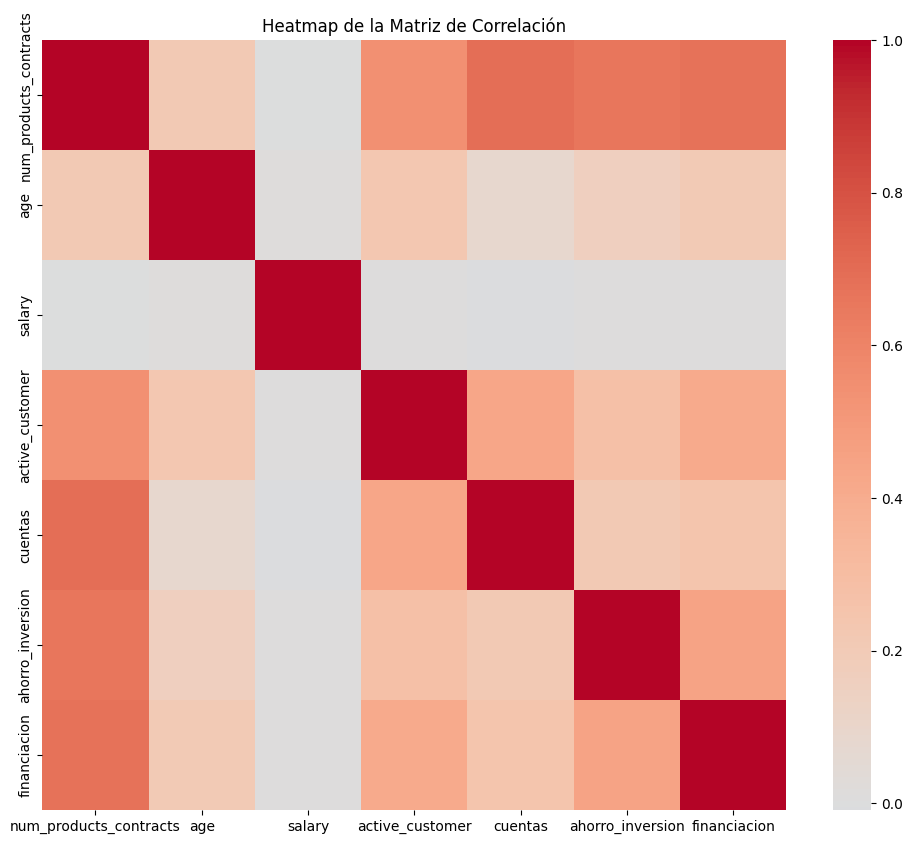

Pares de variables altamente correlacionadas:


In [25]:
# Calcular la matriz de correlación
matriz_correlacion = df_numerico.corr()

# Visualizar la matriz de correlación utilizando un heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacion, cmap='coolwarm', center=0)
plt.title('Heatmap de la Matriz de Correlación')
plt.show()

# Identificar variables altamente correlacionadas
umbral = 0.9
correlaciones_altas = np.where(np.abs(matriz_correlacion) > umbral)
pares_correlacionados = [(matriz_correlacion.index[x], matriz_correlacion.columns[y]) for x, y in zip(*correlaciones_altas) if x != y and x < y]

print("Pares de variables altamente correlacionadas:")
for par in pares_correlacionados:
    print(par)

In [26]:
# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the data
df_numerico_estandarizado = scaler.fit_transform(df_numerico)

# Convert the result to a DataFrame
df_numerico_estandarizado = pd.DataFrame(df_numerico_estandarizado , columns=df_numerico.columns)

# Verify the results
df_numerico_estandarizado

,num_products_contracts,age,salary,active_customer,cuentas,ahorro_inversion,financiacion
0,0.000,2.429,0.320,0.000,-0.773,0.000,0.000
1,-1.000,2.643,0.320,0.000,-1.545,0.000,0.000
2,0.000,3.214,1.213,1.000,-0.258,0.000,0.000
3,1.000,2.357,0.320,1.000,0.687,0.000,0.000
4,2.000,2.071,0.421,1.000,1.455,0.000,0.074
...,...,...,...,...,...,...,...
456368,-1.000,1.929,0.244,0.000,-1.545,0.000,0.000
456369,-1.000,0.357,-0.054,0.000,-1.545,0.000,0.000
456370,-1.000,-0.286,0.000,0.000,-1.545,0.000,0.000
456371,-1.000,1.286,0.244,0.000,-1.545,0.000,0.000


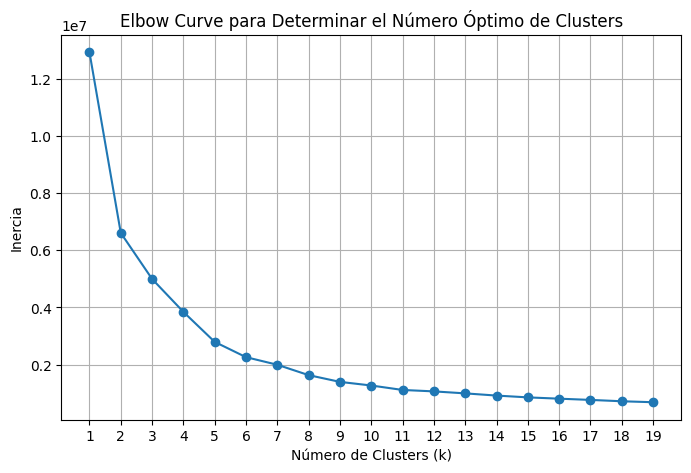

In [27]:
# Definir un rango de k (número de clusters) para probar
rango_k = range(1, 20)
inercias = []

# Aplicar K-means para cada valor de k y calcular la inercia
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_numerico_estandarizado)
    inercias.append(kmeans.inertia_)

# Graficar la Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(rango_k, inercias, marker='o', linestyle='-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Curve para Determinar el Número Óptimo de Clusters')
plt.xticks(rango_k)
plt.grid(True)
plt.show()

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

data = df_numerico_estandarizado.sample(frac=0.1, random_state=42)

# Calcular el coeficiente de silueta para diferentes valores de k
silhouette_scores = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters= k, random_state=42)
    labels = kmeans.fit_predict(data)
    score = silhouette_score(data, labels)
    silhouette_scores[k] = score

# Imprimir los coeficientes de silueta
print(silhouette_scores)

{2: 0.9868588353694703, 3: 0.7266046535865228, 4: 0.547457489429519, 5: 0.43018046359578116, 6: 0.4302369302188937, 7: 0.38141942915781574, 8: 0.3690193266972353, 9: 0.36572743373546024, 10: 0.36180894640444106}
